In [ ]:
!pip install lmdiag
!pip install pyyaml==5.4.1
!pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
     / 17.8 MB 35.9 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
# Mount data từ Google Drive sang Colab
from google.colab import drive
drive.mount('/content/drive')

# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import lmdiag
import itertools
from scipy import stats
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

Mounted at /content/drive


<ipython-input-2-84e1bb7760d5>:16: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


# 1. Đọc dữ liệu

In [ ]:
# Load Dataset
path = '/content/drive/MyDrive/NhapMonKHDL/data_geocode.xlsx' # Đường dẫn tới file cần đọc
df = pd.read_excel(path)  # read_excel từ đường dẫn và trả về dưới dạng một DataFrame
df.head()

Giá cả  Diện tích Hướng nhà Hướng ban công  Số phòng ngủ  Số nhà vệ sinh  \
0    3.30       88.0       NaN            NaN           3.0             2.0   
1    2.60       80.0   Tây-Nam       Đông-Bắc           3.0             2.0   
2    2.05      100.0       NaN            NaN           NaN             NaN   
3    1.40       45.0       NaN            NaN           1.0             1.0   
4    3.45       83.9   Tây-Bắc       Đông-Bắc           3.0             2.0   

      Latitude     Longitude  Vị trí Số tầng  Giấy tờ rõ ràng  \
0  209589392.0  1.058429e+09  Hà Nội     NaN                1   
1  209997545.0  1.059421e+09  Hà Nội     NaN                1   
2  108432686.0  1.068667e+09   other     NaN                1   
3  109570181.0  1.067202e+09   other     NaN                1   
4  209997545.0  1.059421e+09  Hà Nội     NaN                1   

   Hỗ trợ vay vốn ngân hàng  Bàn giao nội thất  
0                         0                  0  
1                         0                  0  
2                         0                  0  
3                         1                  1  
4                         0                  1

# 2. Mô tả và làm sạch dữ liệu

## Đổi tên biến

Vì tên các biến hiện tại có dấu và có khoảng cách, gây khó khăn cho các bước xử lý sau nên ta sẽ đổi lại tên cho các biến.

In [ ]:
df = df.rename(columns={'Giá cả': 'gia_ca',
                        'Diện tích': 'dien_tich',
                        'Hướng nhà': 'huong_nha',
                        'Hướng ban công': 'huong_ban_cong',
                        'Số phòng ngủ': 'phong_ngu',
                        'Số nhà vệ sinh': 'phong_ve_sinh',
                        "Latitude": 'vi_do',
                        "Longitude": 'kinh_do',
                        'Vị trí': 'vi_tri',
                        'Số tầng': 'so_tang',
                        'Giấy tờ rõ ràng': 'giay_to',
                        'Hỗ trợ vay vốn ngân hàng': 'ho_tro_vay',
                        'Bàn giao nội thất': 'noi_that'
                        })

## Mô tả dữ liệu

In [ ]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(' TAIL '.center(70,'-'))
    print(dataframe.tail(head))
    print(' MISSING VALUES '.center(70,'-'))
    print(dataframe.isnull().sum())
    print(' DUPLICATED VALUES '.center(70,'-'))
    print(dataframe.duplicated().sum())

check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 4181
Columns: 13
------------------------------- TYPES --------------------------------
gia_ca            float64
dien_tich         float64
huong_nha          object
huong_ban_cong     object
phong_ngu         float64
phong_ve_sinh     float64
vi_do             float64
kinh_do           float64
vi_tri             object
so_tang            object
giay_to             int64
ho_tro_vay          int64
noi_that            int64
dtype: object
-------------------------------- HEAD --------------------------------
   gia_ca  dien_tich huong_nha huong_ban_cong  phong_ngu  phong_ve_sinh  \
0    3.30       88.0       NaN            NaN        3.0            2.0   
1    2.60       80.0   Tây-Nam       Đông-Bắc        3.0            2.0   
2    2.05      100.0       NaN            NaN        NaN            NaN   
3    1.40       45.0       NaN            NaN        1.0            1.0   
4    3.45       83.9   Tây-Bắc       

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # Giới hạn (Threshold) cho số giá trị duy nhất (unique value) để được coi là 1 biến categorical (cat) hoặc high-carndinality categorical (car)
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'Categorical Columns: {len(cat_cols)}')
    print(f'Numerical Columns: {len(num_cols)}')
    print(f'Categorical but cardinal: {len(cat_but_car)}')
    print(f'Numerical but categorical: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=10)
print(cat_cols, num_cols, cat_but_car, sep='\n')

Observations: 4181
Variables: 13
Categorical Columns: 4
Numerical Columns: 6
Categorical but cardinal: 3
Numerical but categorical: 3
['vi_tri', 'giay_to', 'ho_tro_vay', 'noi_that']
['gia_ca', 'dien_tich', 'phong_ngu', 'phong_ve_sinh', 'vi_do', 'kinh_do']
['huong_nha', 'huong_ban_cong', 'so_tang']


**Nhận xét nhanh:**
*   Có 7 biến bị khuyết dữ liệu là: 'gia_ca', 'dien_tich', 'huong_nha', 'huong_ban_cong', 'phong_ngu', 'phong_ve_sinh' và 'so_tang'.
*   Biến 'huong_nha', 'huong_ban_cong' và 'so_tang' lần lượt bị khuyết khoảng 43.8%, 40.2% và 74.6%. Các biến này không nên điền khuyết (Fill) vì khuyết quá nhiều.
*   Biến 'gia_ca', 'dien_tich', 'phong_ngu' và 'phong_ve_sinh' lần lượt bị khuyết khoảng 10.9%, 3.4%, 7.3% và 13.2%. Ta có thể điền khuyết để xử lý biến này vì phần khuyết nhỏ.
*   Có 917 giá trị trùng nhau, cần phải loại bỏ để tránh việc model bị học quá nhiều 1 quan trắc nào đó.


## Loại bỏ các biến không sử dụng và các giá trị trùng nhau

Loại bỏ 3 biến 'so_tang', 'huong_nha' và 'huong_ban_cong' vì bị khuyết quá nhiều.

In [ ]:
df.drop(['so_tang', 'huong_nha', 'huong_ban_cong'], axis = 1, inplace = True)

Loại bỏ các giá trị trùng nhau.

In [ ]:
df = df.drop_duplicates()
df.dropna(axis=0, subset=['vi_tri', 'gia_ca'], inplace=True)

In [ ]:
check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 2783
Columns: 10
------------------------------- TYPES --------------------------------
gia_ca           float64
dien_tich        float64
phong_ngu        float64
phong_ve_sinh    float64
vi_do            float64
kinh_do          float64
vi_tri            object
giay_to            int64
ho_tro_vay         int64
noi_that           int64
dtype: object
-------------------------------- HEAD --------------------------------
   gia_ca  dien_tich  phong_ngu  phong_ve_sinh        vi_do       kinh_do  \
0    3.30       88.0        3.0            2.0  209589392.0  1.058429e+09   
1    2.60       80.0        3.0            2.0  209997545.0  1.059421e+09   
2    2.05      100.0        NaN            NaN  108432686.0  1.068667e+09   
3    1.40       45.0        1.0            1.0  109570181.0  1.067202e+09   
4    3.45       83.9        3.0            2.0  209997545.0  1.059421e+09   

   vi_tri  giay_to  ho_tro_vay  noi_t

## Xử lý các biến giả (dummy)

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe,
                               columns = categorical_cols,
                               drop_first = drop_first)
    return dataframe

In [ ]:
df = one_hot_encoder(df, ['vi_tri'])
df.head()

gia_ca  dien_tich  phong_ngu  phong_ve_sinh        vi_do       kinh_do  \
0    3.30       88.0        3.0            2.0  209589392.0  1.058429e+09   
1    2.60       80.0        3.0            2.0  209997545.0  1.059421e+09   
2    2.05      100.0        NaN            NaN  108432686.0  1.068667e+09   
3    1.40       45.0        1.0            1.0  109570181.0  1.067202e+09   
4    3.45       83.9        3.0            2.0  209997545.0  1.059421e+09   

   giay_to  ho_tro_vay  noi_that  vi_tri_Hà Nội  vi_tri_Hồ Chí Minh  \
0        1           0         0           True               False   
1        1           0         0           True               False   
2        1           0         0          False               False   
3        1           1         1          False               False   
4        1           0         1           True               False   

   vi_tri_other  
0         False  
1         False  
2          True  
3          True  
4         False

Đổi tên biến dummy để dễ sử dụng hơn.

In [ ]:
df = df.rename(columns={'vi_tri_Hà Nội': 'vi_tri_hn',
                        'vi_tri_Hồ Chí Minh': 'vi_tri_hcm'
                        })

In [ ]:
df['vi_tri_hn'] = df['vi_tri_hn'].apply(lambda x: 1 if x == True else 0)
df['vi_tri_hcm'] = df['vi_tri_hcm'].apply(lambda x: 1 if x == True else 0)
df['vi_tri_other'] = df['vi_tri_other'].apply(lambda x: 1 if x == True else 0)

## Thống kê mô tả


In [ ]:
df.describe()

gia_ca    dien_tich     phong_ngu  phong_ve_sinh         vi_do  \
count  2783.000000  2758.000000   2585.000000    2460.000000  2.677000e+03   
mean      2.867750    75.076385      7.047969       1.798780  1.554479e+08   
std       1.744076    58.105857    221.020154       1.159749  7.352459e+07   
min       0.125300     5.000000      1.000000       1.000000  1.077490e+05   
25%       1.600000    54.000000      2.000000       1.000000  1.080364e+08   
50%       2.400000    69.000000      2.000000       2.000000  1.646371e+08   
75%       3.700000    82.500000      2.000000       2.000000  2.099975e+08   
max       9.920000  2111.000000  11231.000000      30.000000  1.375367e+09   

            kinh_do      giay_to   ho_tro_vay     noi_that    vi_tri_hn  \
count  2.677000e+03  2783.000000  2783.000000  2783.000000  2783.000000   
mean   9.675310e+08     0.899389     0.358246     0.600791     0.470356   
std    2.955219e+08     0.300867     0.479571     0.489824     0.499210   
min   -1.173755e+09     0.000000     0.000000     0.000000     0.000000   
25%    1.057867e+09     1.000000     0.000000     0.000000     0.000000   
50%    1.059428e+09     1.000000     0.000000     1.000000     0.000000   
75%    1.067845e+09     1.000000     1.000000     1.000000     1.000000   
max    1.092787e+09     1.000000     1.000000     1.000000     1.000000   

        vi_tri_hcm  vi_tri_other  
count  2783.000000   2783.000000  
mean      0.216313      0.313331  
std       0.411804      0.463931  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      1.000000  
max       1.000000      1.000000

Dùng pandas profilling để thực hiện EDA nhanh.

In [ ]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

In [ ]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Kiểm tra mối tương quan theo cặp (Pairwise Correlation).

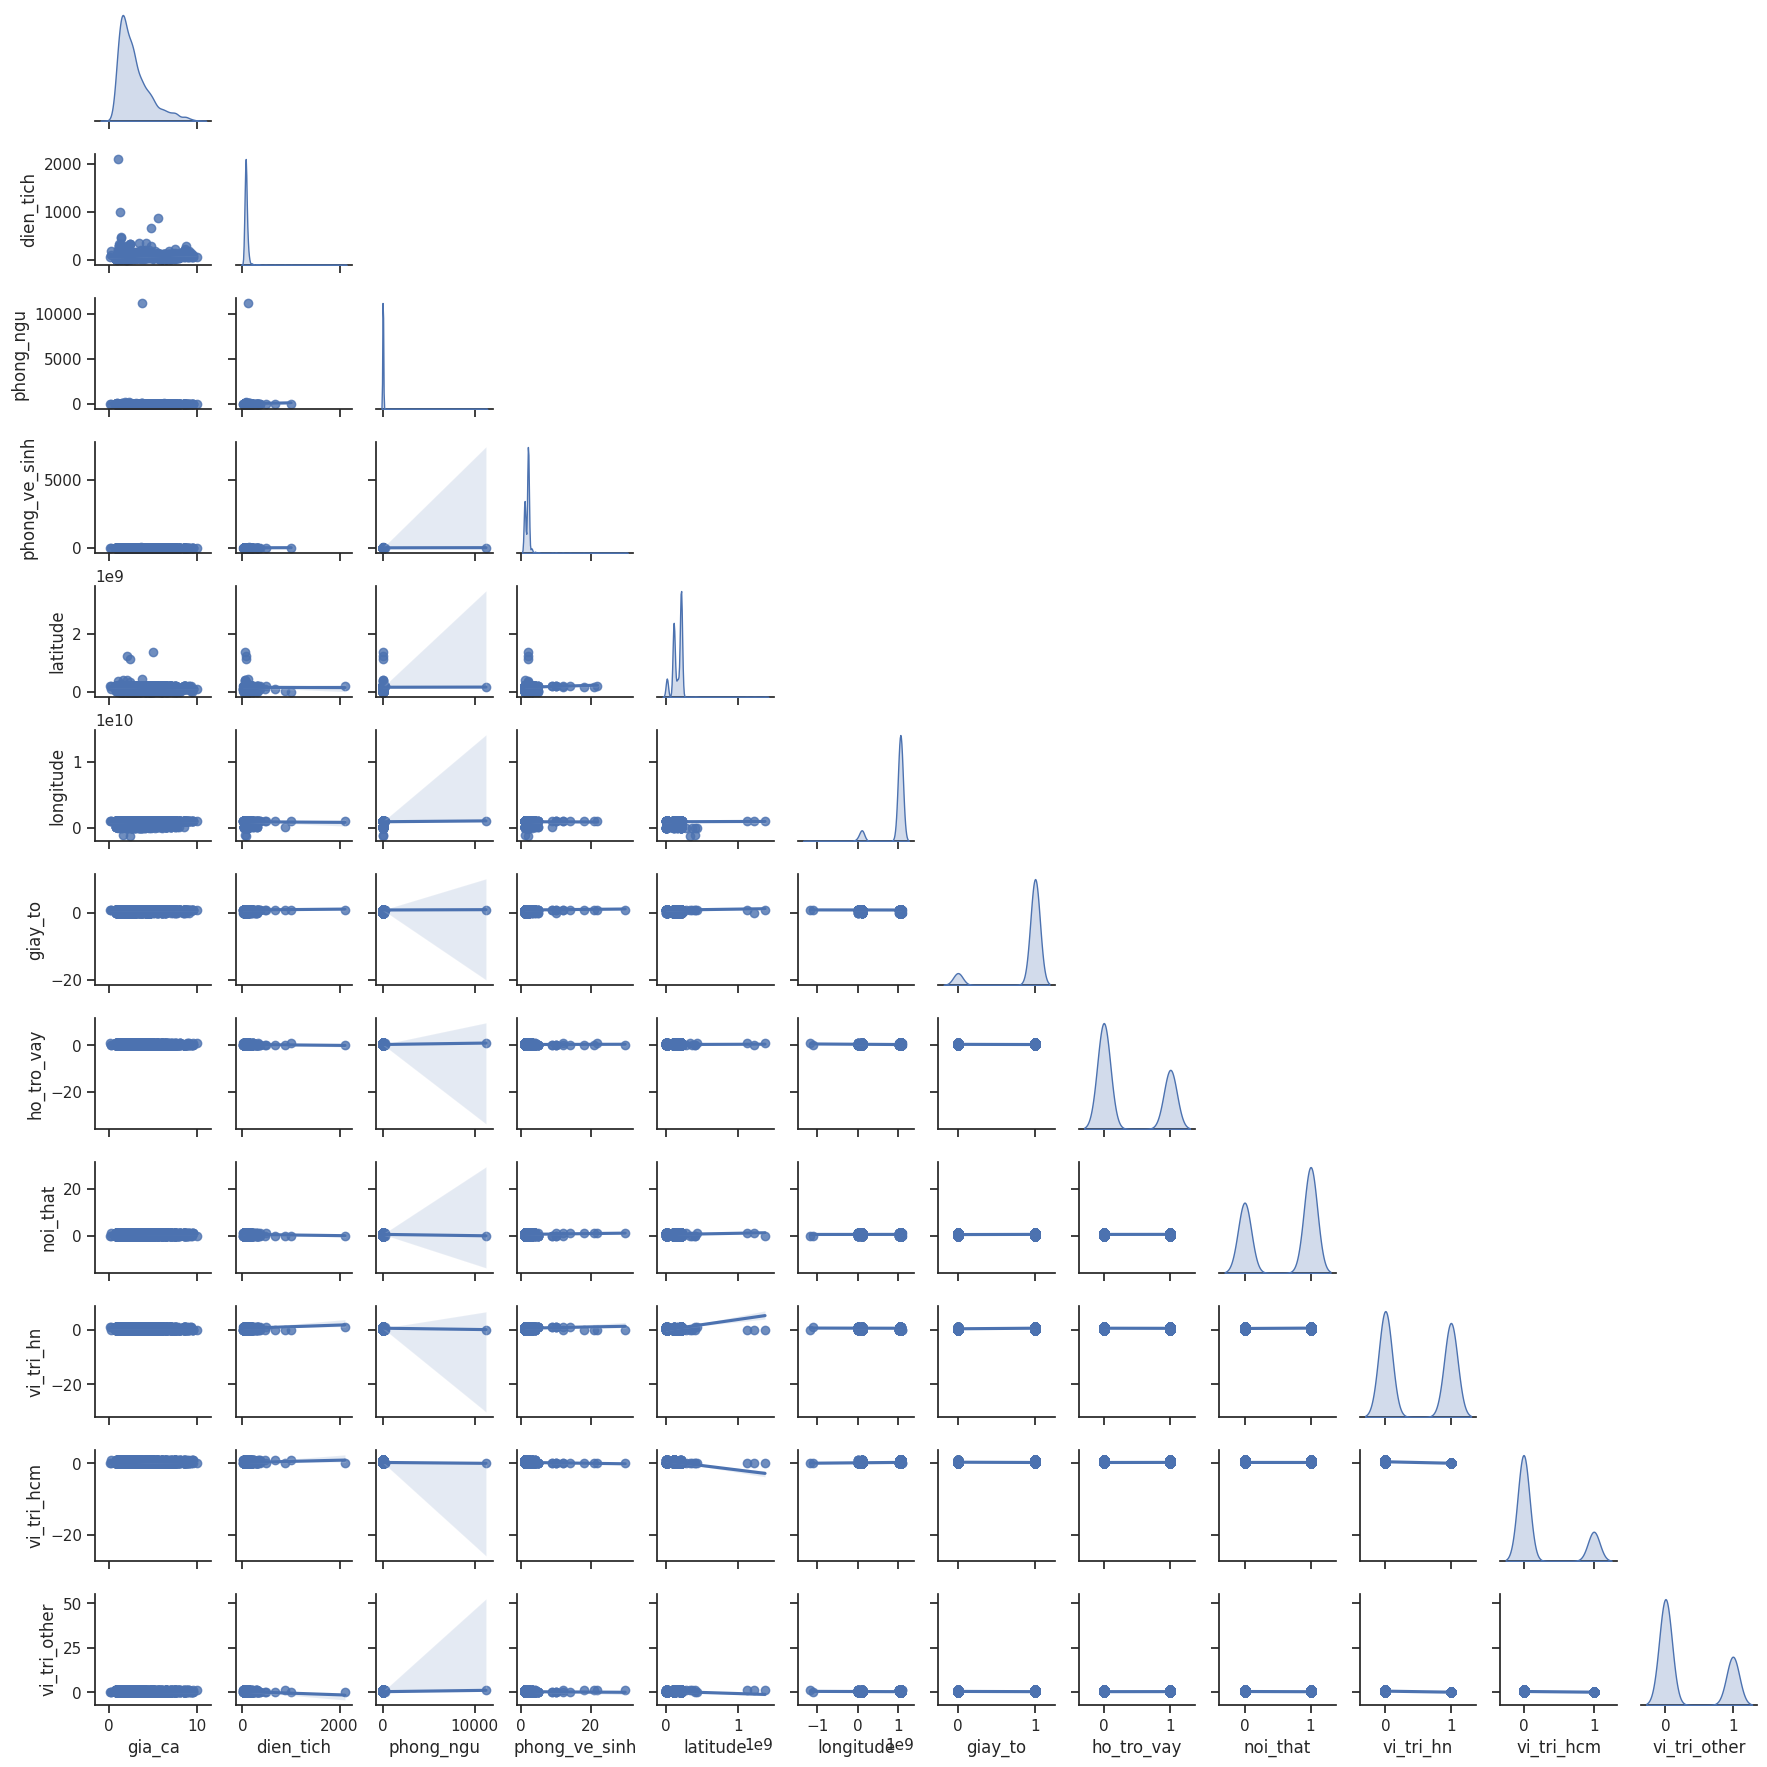

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(df, kind='reg', diag_kind='kde', height=1.5, corner=True)
plt.show()

Kiểm tra kĩ hơn về phân phối của các biến.

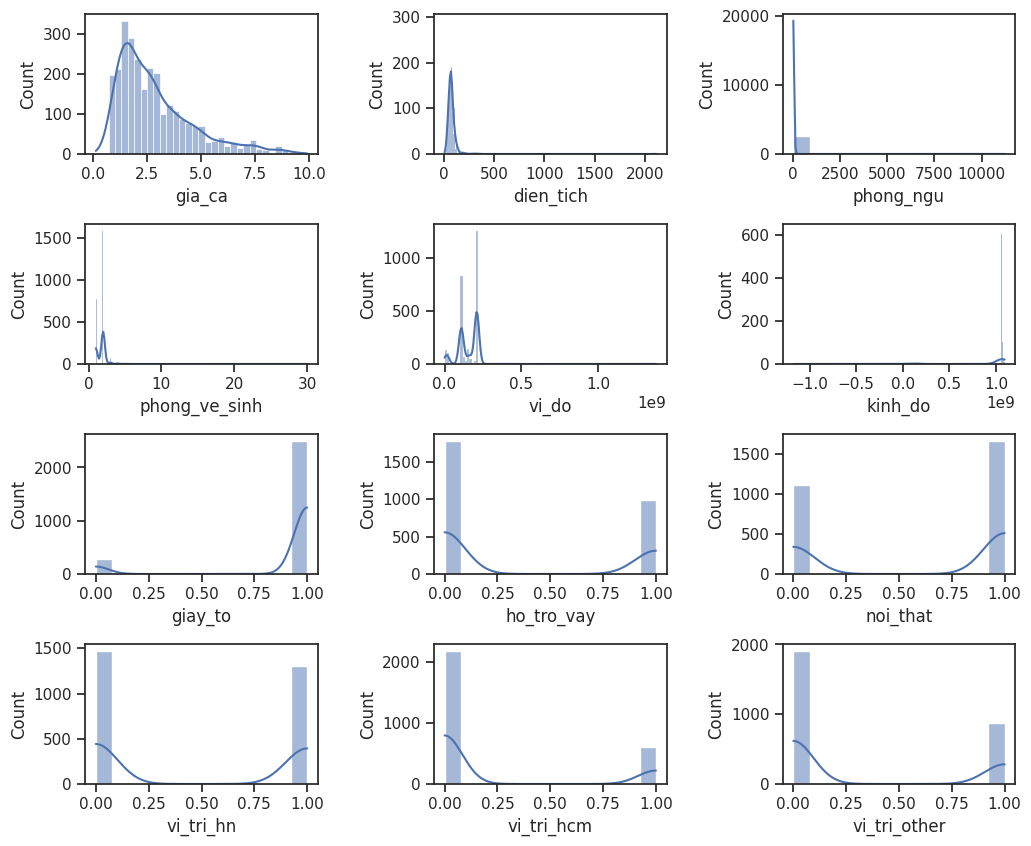

In [ ]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(df.columns, 1):
  plt.subplot(4, 3, i)
  plt.subplots_adjust(hspace=0.5, wspace=0.5)
  sns.histplot(df[column], kde=True)
plt.show()

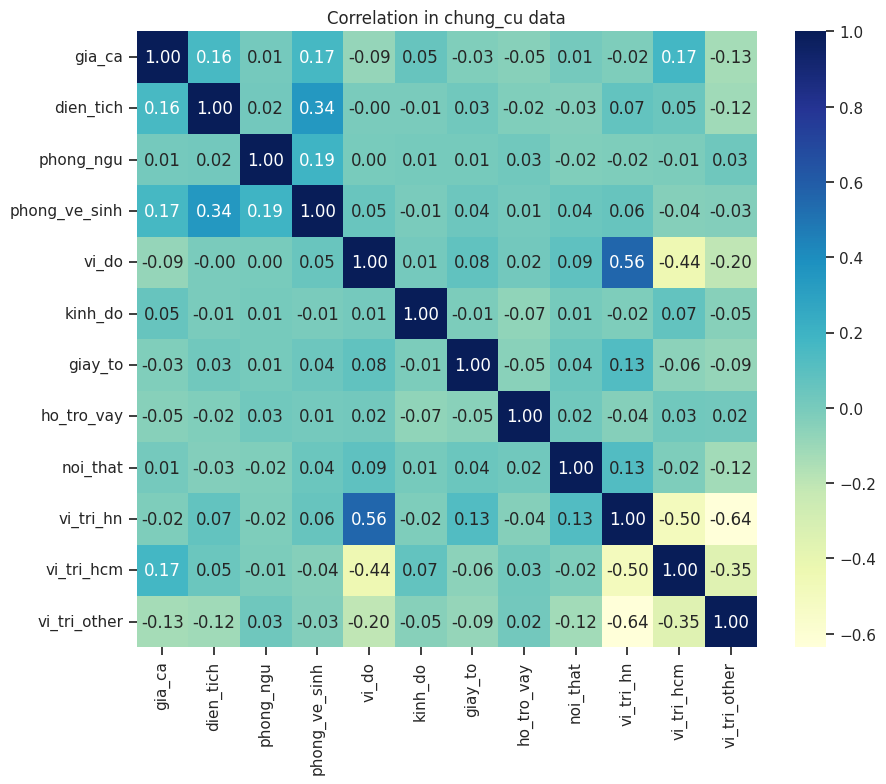

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Correlation in chung_cu data')
plt.show()

**Nhận xét tổng quan:**

*   Biến 'gia_ca' có khuynh hướng lệch phải, các biến 'dien_tich', 'phong_ngu' và 'phong_ve_sinh' bị lệch phải rất nặng. Điều này có thể do các giá trị ngoại lai (outlier) rất lớn tạo ra.
*   Hầu hết các biến đều là biến categorical, điều này có thể dẫn tới kết quả không tốt khi sử dụng mô hình tuyến tính.
*   Khoảng giá trị của các biến không giống nhau.
*   Bởi vì dữ liệu vẫn còn bị khuyết giá trị ở một số biến và bị lệch (skewed) rất nặng nên tương quan giữa các biến như biểu diễn ở trên sẽ có thể thay đổi sau khi xử lý. Ta sẽ quan sát và nhận xét lại sau khi xử lý xong các vấn đề trên.


## Loại bỏ các giá trị ngoại lai (Outlier)


Đối với biến 'phong_ngu' và 'phong_ve_sinh' ta sẽ quan sát số lượng của các giá trị duy nhất và dựa vào sự hợp lý trong thực tế để loại bỏ các giá trị ngoại lai (outlier).



In [ ]:
print(df['phong_ngu'].value_counts())
print(df['phong_ve_sinh'].value_counts())

phong_ngu
2.0        1404
1.0         568
3.0         505
4.0          56
13.0         10
5.0           8
23.0          7
123.0         6
10.0          3
12.0          3
11.0          2
40.0          2
30.0          2
17.0          1
32.0          1
25.0          1
14.0          1
223.0         1
234.0         1
11231.0       1
24.0          1
7.0           1
Name: count, dtype: int64
phong_ve_sinh
2.0     1586
1.0      771
3.0       66
4.0       18
5.0        7
10.0       3
12.0       2
9.0        2
30.0       1
21.0       1
18.0       1
14.0       1
22.0       1
Name: count, dtype: int64


Ở đây, ta thấy cả 2 biến đều có hầu hết số lượng đều nằm trong các giá trị từ 1 đến 4. Điều này cũng sát với thực tế vì các chung cư ta thường thấy cũng chỉ có số phòng ngủ, số phòng vệ sinh nằm trong khoảng giá trị này (chỉ trừ một vài "siêu" chung cư có thể có nhiều hơn nhưng không đáng kể).

In [ ]:
df = df[df['phong_ngu'] <= 4]
df = df[df['phong_ve_sinh'] <= 4]

Loại bỏ các giá trị ngoại lai bằng IQR.

In [ ]:
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[df[col] <= q3 + 1.5 * iqr]
    df = df[df[col] >= q1 - 1.5 * iqr]
    return df

In [ ]:
df = remove_outliers(df, 'dien_tich')
df = remove_outliers(df, 'kinh_do')
df = remove_outliers(df, 'vi_do')

Kiểm tra lại dữ liệu sau khi loại bỏ các giá trị ngoại lai.

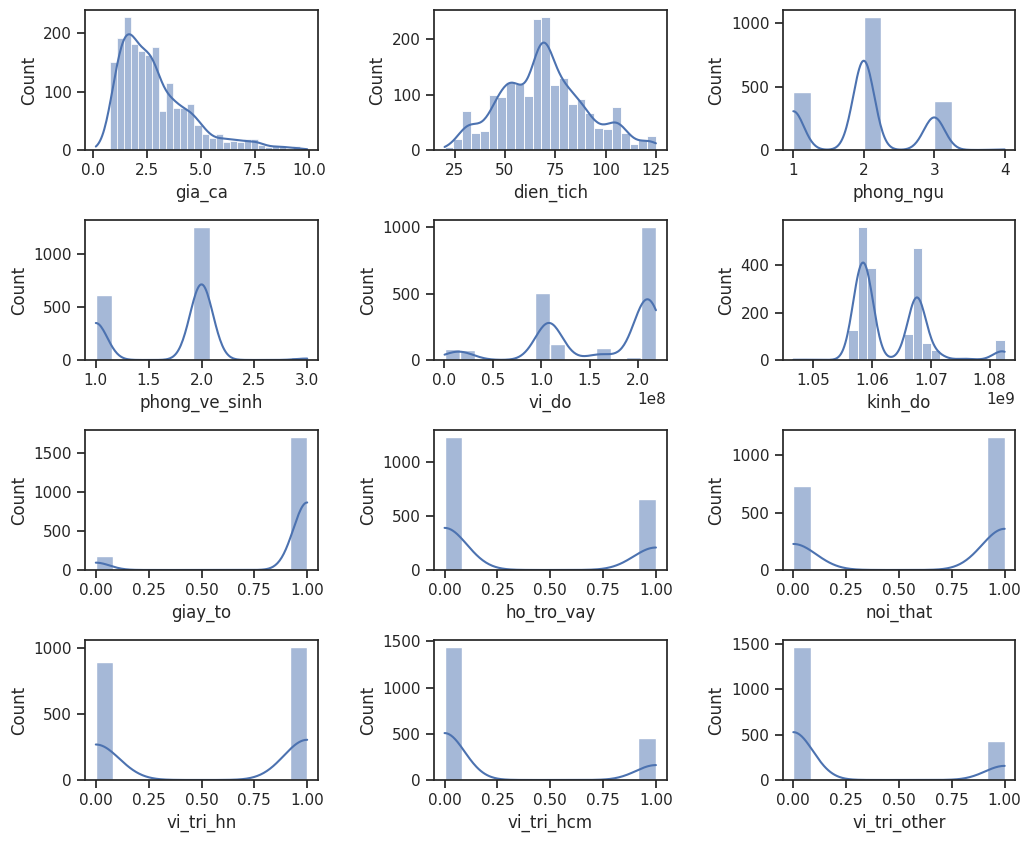

In [ ]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(df.columns, 1):
  plt.subplot(4, 3, i)
  plt.subplots_adjust(hspace=0.5, wspace=0.5)
  sns.histplot(df[column], kde=True)
plt.show()

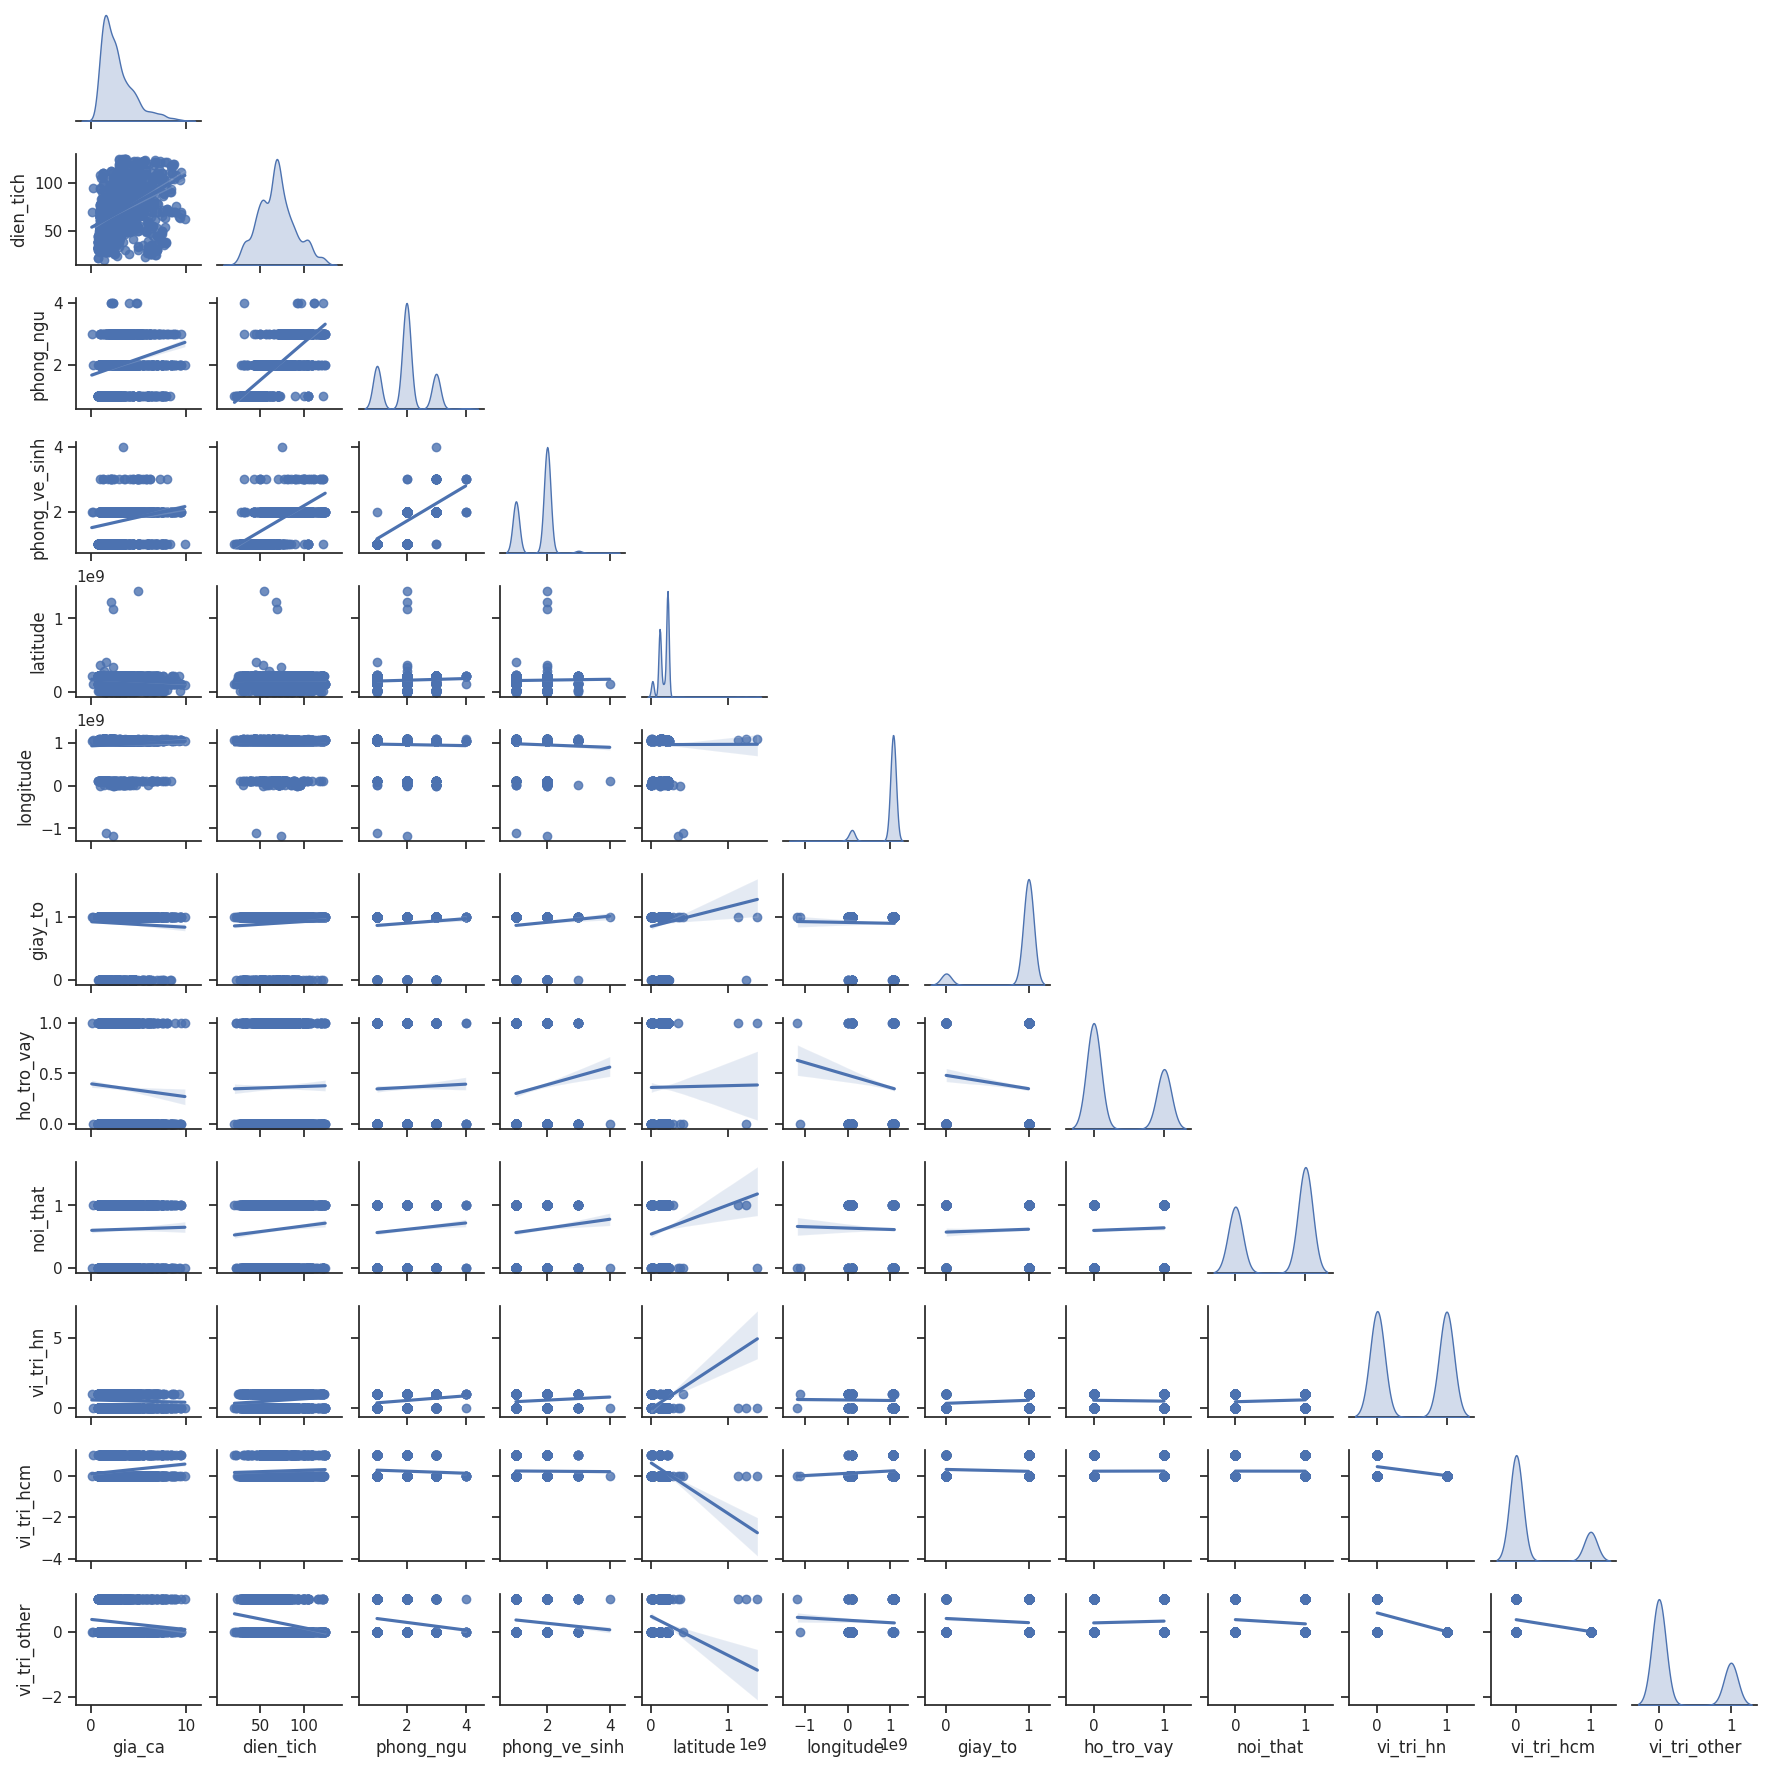

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(df, kind='reg', diag_kind='kde', height=1.5, corner=True)
plt.show()

In [ ]:
check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 1900
Columns: 12
------------------------------- TYPES --------------------------------
gia_ca           float64
dien_tich        float64
phong_ngu        float64
phong_ve_sinh    float64
vi_do            float64
kinh_do          float64
giay_to            int64
ho_tro_vay         int64
noi_that           int64
vi_tri_hn          int64
vi_tri_hcm         int64
vi_tri_other       int64
dtype: object
-------------------------------- HEAD --------------------------------
   gia_ca  dien_tich  phong_ngu  phong_ve_sinh        vi_do       kinh_do  \
0    3.30       88.0        3.0            2.0  209589392.0  1.058429e+09   
1    2.60       80.0        3.0            2.0  209997545.0  1.059421e+09   
3    1.40       45.0        1.0            1.0  109570181.0  1.067202e+09   
4    3.45       83.9        3.0            2.0  209997545.0  1.059421e+09   
5    4.00      104.0        2.0            2.0  209589392.0  1.05

**Nhận xét tổng quan:**

*   Sau khi loại bỏ các biến ngoại lai thì biến 'dien_tich' đã không còn bị lệch phải, tuy nhiên các biến 'gia_ca', 'phong_ngu' và 'phong_ve_sinh' vẫn còn bị lệch phải dù đã đỡ hơn.
*   Sau khi loại bỏ các giá trị ngoại lai, các biến 'phong_ngu' và 'phong_ve_sinh' gần như đã trở thành biến categorical khi chỉ chứa 4 giá trị duy nhất. Điều này sẽ càng làm kết quả của mô hình tuyến tính (nếu sử dụng) tệ hơn khi chỉ còn duy nhất biến 'dien_tich' là có giá trị liên tục.
*   Sau khi loại bỏ các giá trị ngoại lai, rất may mắn bộ dữ liệu cũng không còn bị khuyết (missing values). Điều này cho thấy các giá trị bị khuyết đều nằm trong khoảng ngoại lai mà ta đã loại bỏ.
*   Do không còn các giá trị ngoại lai và dữ liệu không còn bị khuyết, ta có thể vẽ biểu đồ thể hiện tương quan giữa các biến và nhận xét.
*   Biến phụ thuộc 'gia_ca' không có tương quan mạnh với bất kì biến độc lập nào. Điều này có thể dẫn tới kết quả không tốt khi sử dụng mô hình tuyến tính vì vi phạm giả định các biến độc lập có tương quan tuyến tính với biến phụ thuộc.
*   Biến độc lập có tương quan mạnh nhất với biến 'gia_ca' là biến 'phong_ngu' với tương quan thuận 0.32.
*   Giữa các biến 'dien_tich', 'phong_ngu' và 'phong_ve_sinh' có mối tương quan thuận mạnh. Điều này là đúng với thực tế vì thường các phòng chung cư có diện tích càng lớn thì số phòng ngủ và phòng vệ sinh cũng càng nhiều. Điều này dễ dẫn tới hiện tượng đa cộng tuyến khi xây dựng mô hình tuyến tính.

## Xử lý các giá trị khuyết (Missing values)

In [ ]:
df[df['latitude'].isna()]

gia_ca  dien_tich  phong_ngu  phong_ve_sinh  latitude  longitude  \
52      2.40       65.0        2.0            2.0       NaN        NaN   
75      1.65       45.0        1.0            1.0       NaN        NaN   
108     2.40       65.0        2.0            2.0       NaN        NaN   
111     2.60       72.0        3.0            2.0       NaN        NaN   
134     2.60       72.0        3.0            2.0       NaN        NaN   
...      ...        ...        ...            ...       ...        ...   
3991    1.00       55.0        2.0            1.0       NaN        NaN   
4036    1.70       43.0        1.0            1.0       NaN        NaN   
4066    1.00       53.0        2.0            1.0       NaN        NaN   
4101    1.70       45.0        1.0            1.0       NaN        NaN   
4125    1.00       64.0        2.0            2.0       NaN        NaN   

      giay_to  ho_tro_vay  noi_that  vi_tri_hn  vi_tri_hcm  vi_tri_other  
52          1           0         1          0           1             0  
75          1           0         0          0           0             1  
108         1           0         1          0           0             1  
111         1           0         1          0           0             1  
134         1           0         1          1           0             0  
...       ...         ...       ...        ...         ...           ...  
3991        1           1         1          0           0             1  
4036        1           0         1          1           0             0  
4066        1           1         1          0           0             1  
4101        1           0         0          1           0             0  
4125        1           0         1          0           0             1  

[88 rows x 12 columns]

In [ ]:
def fill_missing_values(df, col):
    df_temp = df[~df[col].isna()]
    X_complete = df_temp.drop(['latitude', 'longitude'], axis=1) #Do regression tree là mô hình thống kê phi tham số, ta loại bỏ các biến này để giảm tác động của curse of dimensionality
    y_complete = df_temp[col].to_numpy()
    X_NA = df[df[col].isna()].drop(['latitude', 'longitude'], axis=1)
    return X_complete, y_complete, X_NA

In [ ]:
for col in ['latitude', 'longitude']:
    X_complete, y_complete, X_NA = fill_missing_values(df, col)
    regr = DecisionTreeRegressor(random_state=1)
    regr.fit(X_complete, y_complete)
    y_NA = regr.predict(X_NA)
    y_NA = pd.Series(y_NA, index=X_NA.index)
    df[col] = df[col].fillna(y_NA)

KeyError: 'latitude'

In [ ]:
# Kiểm tra lại
print(df['latitude'].isna().any(), df['longitude'].isna().any()),
print(df['latitude'].loc[y_NA.index])
print(df['longitude'].loc[y_NA.index])

In [ ]:
check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 2310
Columns: 12
------------------------------- TYPES --------------------------------
gia_ca           float64
dien_tich        float64
phong_ngu        float64
phong_ve_sinh    float64
latitude         float64
longitude        float64
giay_to            int64
ho_tro_vay         int64
noi_that           int64
vi_tri_hn          int64
vi_tri_hcm         int64
vi_tri_other       int64
dtype: object
-------------------------------- HEAD --------------------------------
   gia_ca  dien_tich  phong_ngu  phong_ve_sinh     latitude     longitude  \
0    3.30       88.0        3.0            2.0  209589392.0  1.058429e+09   
1    2.60       80.0        3.0            2.0  209997545.0  1.059421e+09   
3    1.40       45.0        1.0            1.0  109570181.0  1.067202e+09   
4    3.45       83.9        3.0            2.0  209997545.0  1.059421e+09   
5    4.00      104.0        2.0            2.0  209589392.0  1.05

In [ ]:
df = df.drop_duplicates()

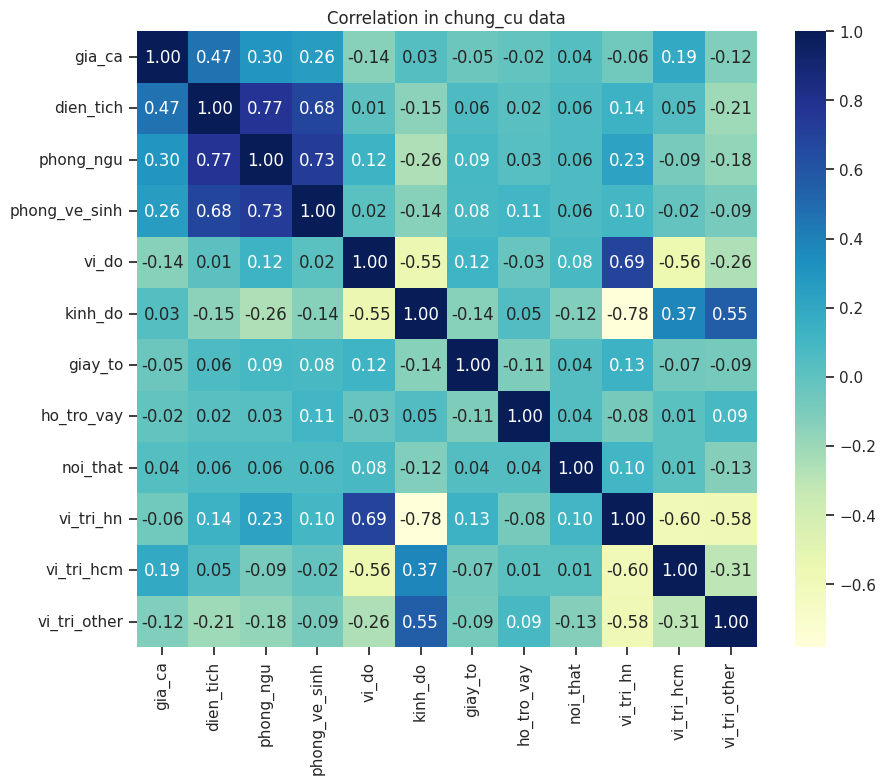

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Correlation in chung_cu data')
plt.show()

# 3. Huấn luyện mô hình

## Chia tập Train-test

In [ ]:
def prepare_X_y(df):
    # Chia dữ liệu thành X (biến độc lập) và y (biến phụ thuộc). Trả về 2 dataframe
    columns = df.columns.tolist()
    columns.remove('gia_ca')
    X = df[columns] # Chọn các cột chứa feature
    y = df['gia_ca'] # Chọn cột chứa giá trị cần dự đoán
    return X, y

X, y = prepare_X_y(df)
print(X.shape)
print(y.shape)

(1900, 11)
(1900,)


In [ ]:
def split_train_test(X, y, train_size=0.8):
    # Dùng hàm train_test_split để chia X và y thành 2 tập: train và test
    # Với train_size là tỉ lệ của tập train và cố định random_state để không bị thay đổi kết quả
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=True, random_state=0)
    print(f"Training set size: \tX_train: {X_train.shape} \tY_train: {y_train.shape}")
    print(f"Testing set size: \tX_test: {X_test.shape} \ty_train: {y_test.shape}")
    return X_train, X_test, y_train, y_test

In [ ]:
TRAIN_SIZE = 0.8 # Chọn tỉ lệ tập Train

X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=TRAIN_SIZE)

Training set size: 	X_train: (1520, 11) 	Y_train: (1520,)
Testing set size: 	X_test: (380, 11) 	y_train: (380,)


## Khởi tạo mô hình Linear Regression

In [ ]:
def build_linear_model(X, y):
    # X, y nên lấy từ tập Train
    # Tách tên của các biến X, y để viết hàm hồi quy
    X_variable = list(X.columns.values)
    y_variable = y.name
    data = pd.concat([X, y], axis=1, join='inner')
    formula = y_variable + '~' +'+'.join(X_variable)
    # Dùng hàm Ordinary Least Squares regression (OLS) từ sklearn, input là hàm hồi quy (có bias) và dữ liệu của các biến (X, y)
    model = smf.ols(formula=formula, data=data)
    # Fit/Train model
    results = model.fit()
    return results

# Huấn luyện mô hình với tập Train
model = build_linear_model(X_train, y_train)

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 gia_ca   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     50.17
Date:                Wed, 19 Jun 2024   Prob (F-statistic):           4.71e-87
Time:                        10:35:57   Log-Likelihood:                -2735.0
No. Observations:                1520   AIC:                             5492.
Df Residuals:                    1509   BIC:                             5551.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.6786      7.962      0.462      0.644     -11.939      19.296
dien_tich         0.0432      0.003     14.290      0.000       0.037       0.049
phong_ngu        -0.0984      0.102     -0.965      0.334      -0.298       0.102
phong_ve_sinh    -0.2321      0.119     -1.952      0.051      -0.465       0.001
vi_do          -1.73e-09    8.6e-10     -2.011      0.044   -3.42e-09   -4.28e-11
kinh_do       -3.546e-09   9.94e-09     -0.357      0.721    -2.3e-08     1.6e-08
giay_to          -0.3364      0.130     -2.596      0.010      -0.591      -0.082
ho_tro_vay       -0.1197      0.081     -1.487      0.137      -0.278       0.038
noi_that          0.0110      0.079      0.140      0.889      -0.144       0.166
vi_tri_hn         1.0522      2.593      0.406      0.685      -4.034       6.139
vi_tri_hcm        1.5378      2.673      0.575      0.565      -3.705       6.780
vi_tri_other      1.0886      2.699      0.403      0.687      -4.206       6.383
==============================================================================
Omnibus:                      599.619   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2482.757
Skew:                           1.887   Prob(JB):                         0.00
Kurtosis:                       7.997   Cond. No.                     8.75e+23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.29e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

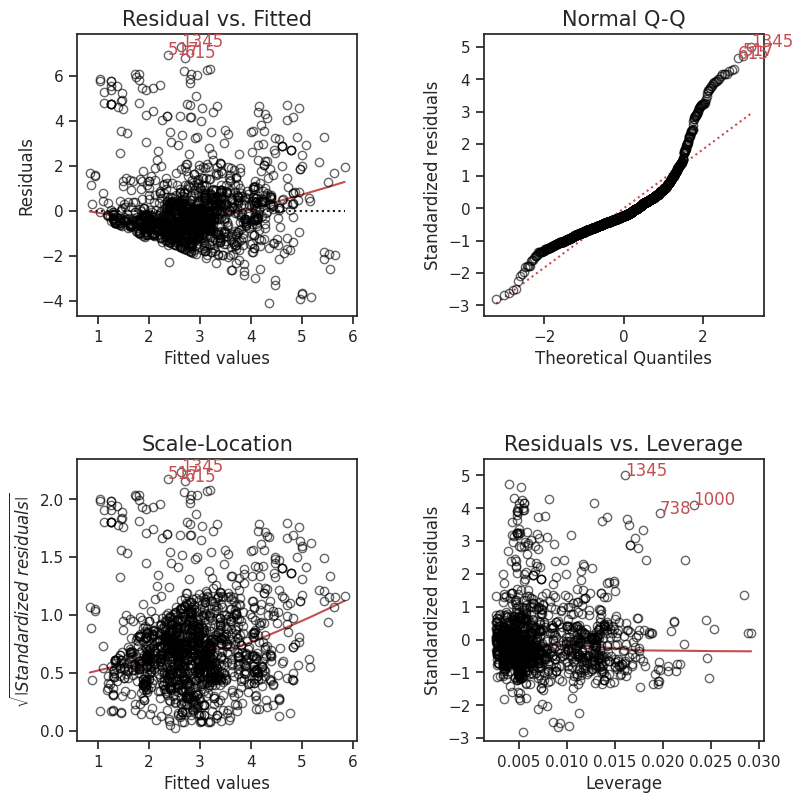

In [ ]:
plt.figure(figsize=(8, 8))
lmdiag.plot(model);

In [ ]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [ ]:
X = df.drop(['gia_ca'], axis=1)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

          Feature           VIF
0       dien_tich      2.837209
1       phong_ngu      3.322697
2   phong_ve_sinh      2.409463
3           vi_do      2.091520
4         kinh_do      2.785615
5         giay_to      1.040848
6      ho_tro_vay      1.044019
7        noi_that      1.027598
8       vi_tri_hn  42197.663596
9      vi_tri_hcm  19438.670862
10   vi_tri_other  18461.736692


In [ ]:
train_score=[]
test_score=[]
for i in range (1,21):
    train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    regr = RandomForestRegressor(max_depth=i,random_state=0)
    regr.fit(X_train, y_train)
    train_score.append(regr.score(X_train, y_train))
    test_score.append(regr.score(X_test, y_test))
y_pred = regr.predict(X_test)

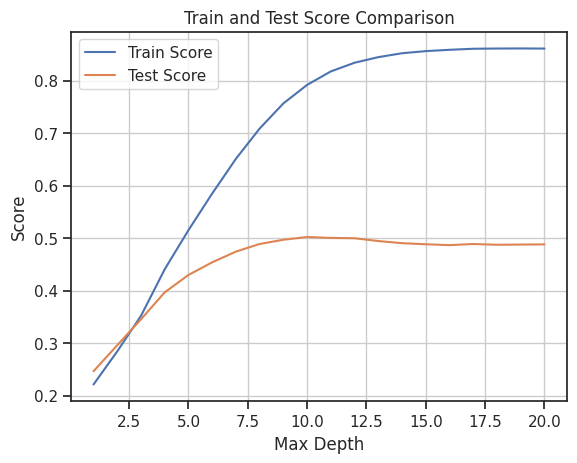

In [ ]:
# prompt: plot line graph of train and test score on 1 graph

import matplotlib.pyplot as plt

# Plot the training and testing scores on the same graph
plt.plot(range(1, 21), train_score, label="Train Score")
plt.plot(range(1, 21), test_score, label="Test Score")

# Add labels and title
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.title("Train and Test Score Comparison")

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
train_score=[]
test_score=[]
for i in np.arange(0.05, 1, 0.05):
    regr = RandomForestRegressor(max_depth=11, max_features=i, random_state=0)
    regr.fit(X_train, y_train)
    train_score.append(regr.score(X_train, y_train))
    test_score.append(regr.score(X_test, y_test))
y_pred = regr.predict(X_test)

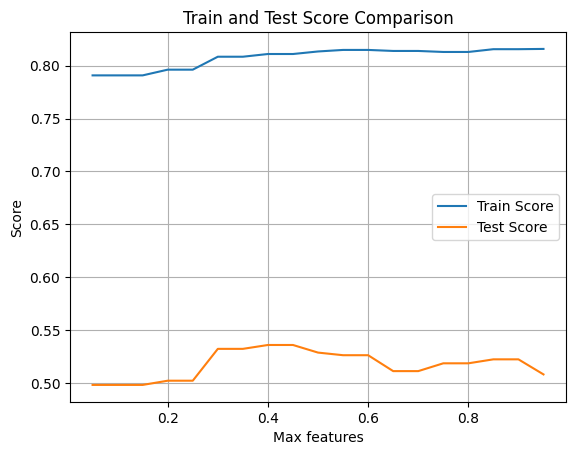

In [ ]:
# prompt: plot line graph of train and test score on 1 graph

import matplotlib.pyplot as plt

# Plot the training and testing scores on the same graph
plt.plot(np.arange(0.05, 1, 0.05), train_score, label="Train Score")
plt.plot(np.arange(0.05, 1, 0.05), test_score, label="Test Score")

# Add labels and title
plt.xlabel("Max features")
plt.ylabel("Score")
plt.title("Train and Test Score Comparison")

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
regr = RandomForestRegressor(max_depth=11, max_features=0.3, random_state=0, oob_score=True)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [ ]:
print("Train R2: ", regr.score(X_train, y_train))
print("Test R2: ", regr.score(X_test, y_test))

Train R2:  0.8084154066390828
Test R2:  0.5321972347074433


In [ ]:
print(regr.oob_score_)

0.4431391334867114


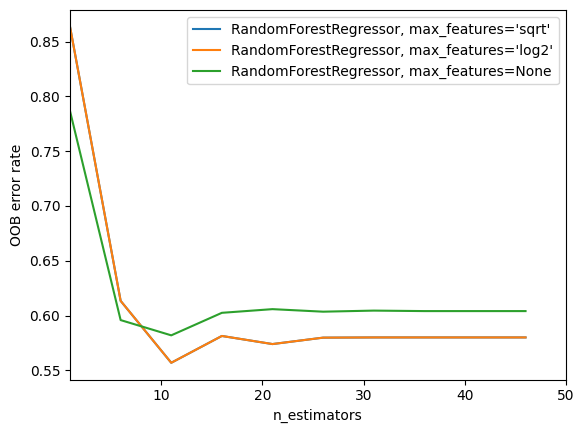

In [ ]:
from collections import OrderedDict

ensemble_regr = [
    (
        "RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(
            oob_score=True,
            max_features="sqrt",
            random_state=0,
        ),
    ),
    (
        "RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(
            max_features="log2",
            oob_score=True,
            random_state=0,
        ),
    ),
    (
        "RandomForestRegressor, max_features='None'",
        RandomForestRegressor(
            max_features=None,
            oob_score=True,
            random_state=0,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_regr)

# Range of `n_estimators` values to explore.
min_depth = 1
max_depth = 50
min_error = float("inf")
best_depth = None

for label, regr in ensemble_regr:
    for i in range(min_depth, max_depth + 1, 5):
        regr.set_params(max_depth=i)
        regr.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - regr.oob_score_
        error_rate[label].append((i, oob_error))
        if oob_error < min_error:
            min_error = oob_error
            best_depth = i

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, regr_err in error_rate.items():
    xs, ys = zip(*regr_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_depth, max_depth)
plt.xlabel("max_depth")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:
print(min_error, best_depth)

0.5568608665132886 11


In [ ]:
from sklearn.metrics import mean_squared_error

y_pred_train = regr.predict(X_train)
print("Train MSE: ", mean_squared_error(y_pred_train, y_train))
y_pred_test = regr.predict(X_test)
print("Test MSE: ", mean_squared_error(y_pred_test, y_test))

Train MSE:  0.39486788185643046
Test MSE:  1.31541157490258


In [ ]:
data_train = {'y_pred_train': y_pred_train, 'y_train': y_train}
results_train = pd.DataFrame(data_train, columns=['y_pred_train', 'y_train'])
data_test = {'y_pred_test': y_pred_test, 'y_test': y_test}
results_test = pd.DataFrame(data_test, columns=['y_pred_test', 'y_test'])

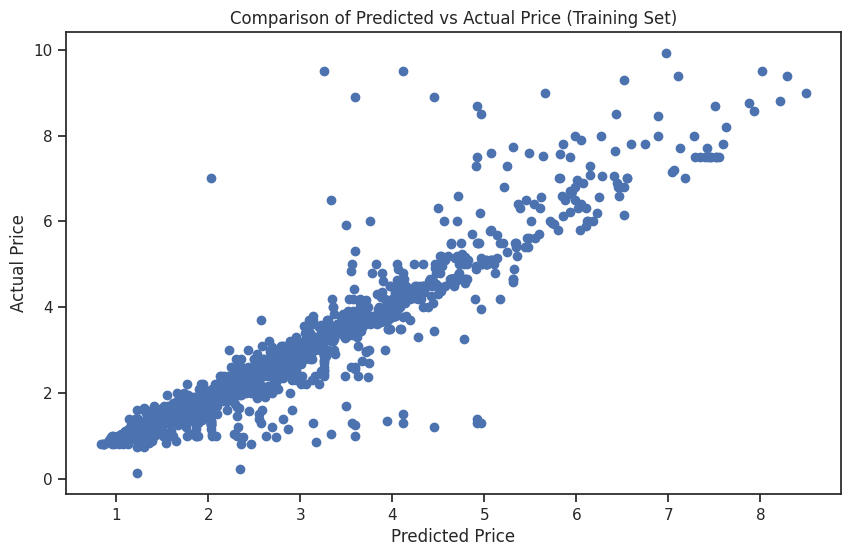

In [ ]:
# prompt: plot suitable graph to compare 2 columns in results

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(results_train['y_pred_train'], results_train['y_train'])
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Comparison of Predicted vs Actual Price (Training Set)')
plt.show()


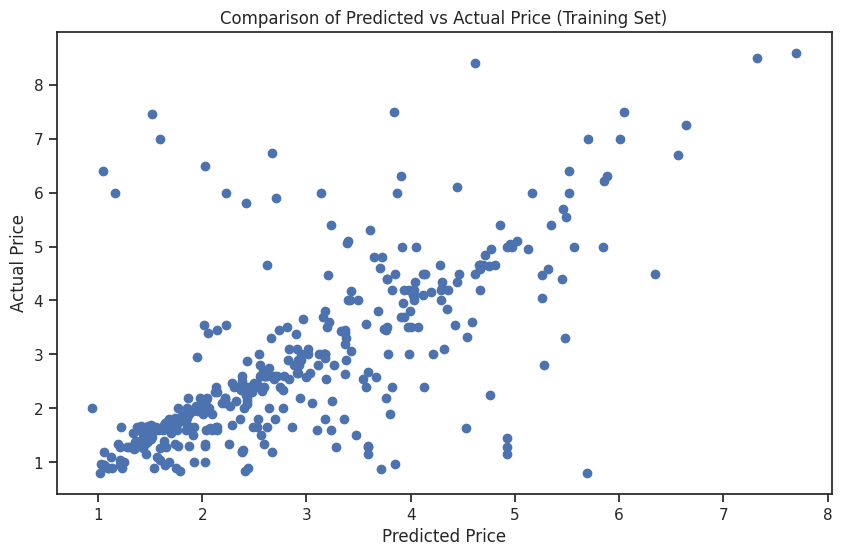

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(results_test['y_pred_test'], results_test['y_test'])
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Comparison of Predicted vs Actual Price (Training Set)')
plt.show()

In [ ]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
X = df.drop('gia_ca', axis=1).values  # Convert to numpy array
y = df['gia_ca'].values  # Convert to numpy array

In [ ]:
X_std = (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 1)
y_std = (y - y.mean(axis = 0))/y.std(axis = 0, ddof = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y_std, test_size=0.2, random_state=0)

In [ ]:
# Convert the data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
class RealEstateModel(nn.Module):
    def __init__(self, input_dim):
        super(RealEstateModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train_torch.shape[1]
model = RealEstateModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training parameters
epochs = 100
batch_size = 32

# Create data loaders
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

Epoch 1/100, Loss: 0.8710244130343199
Epoch 2/100, Loss: 0.7550762010117372
Epoch 3/100, Loss: 0.7196846439813575
Epoch 4/100, Loss: 0.726787822941939
Epoch 5/100, Loss: 0.6988811405996481
Epoch 6/100, Loss: 0.6968522695824504
Epoch 7/100, Loss: 0.6893336934347948
Epoch 8/100, Loss: 0.6740781425808867
Epoch 9/100, Loss: 0.6711718359341224
Epoch 10/100, Loss: 0.6581491629282633
Epoch 11/100, Loss: 0.6554286830748121
Epoch 12/100, Loss: 0.647680138858656
Epoch 13/100, Loss: 0.650588806408147
Epoch 14/100, Loss: 0.6440572086721659
Epoch 15/100, Loss: 0.6302917003631592
Epoch 16/100, Loss: 0.6231376662229499
Epoch 17/100, Loss: 0.6128147058188915
Epoch 18/100, Loss: 0.6092015908410152
Epoch 19/100, Loss: 0.6097991882512966
Epoch 20/100, Loss: 0.6018661987036467
Epoch 21/100, Loss: 0.5972087951377034
Epoch 22/100, Loss: 0.5978951388970017
Epoch 23/100, Loss: 0.5876151773457726
Epoch 24/100, Loss: 0.5848511404668292
Epoch 25/100, Loss: 0.5784864428763589
Epoch 26/100, Loss: 0.588497059730192

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_torch)
    test_loss = criterion(test_outputs, y_test_torch)
    print(f'Test Loss: {test_loss.item()}')

Test Loss: 0.662687361240387


In [ ]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
    return predictions

# Example: Predict on test data
y_pred = predict(model, X_test_torch)
print(y_pred - y_test)
y_pred = y_pred*y.std(axis = 0, ddof = 1) + y.mean(axis = 0)
y_test = y_test*y.std(axis = 0, ddof = 1) + y.mean(axis = 0)
print(y_pred, y_test)

tensor([[ 0.1049,  1.3249, -0.0386,  ...,  0.7149, -0.6785,  1.4864],
        [ 0.4721,  1.6921,  0.3286,  ...,  1.0821, -0.3113,  1.8536],
        [ 0.3121,  1.5322,  0.1686,  ...,  0.9222, -0.4713,  1.6936],
        ...,
        [-0.5798,  0.6402, -0.7233,  ...,  0.0302, -1.3632,  0.8017],
        [ 2.7455,  3.9655,  2.6020,  ...,  3.3555,  1.9621,  4.1270],
        [-0.5346,  0.6854, -0.6782,  ...,  0.0754, -1.3181,  0.8468]],
       dtype=torch.float64)
tensor([[3.3654],
        [3.9795],
        [3.7119],
        [2.2130],
        [3.0440],
        [1.4888],
        [5.1115],
        [4.7282],
        [2.9690],
        [1.8779],
        [1.7154],
        [2.9301],
        [1.0609],
        [5.1778],
        [2.4877],
        [3.0480],
        [1.6264],
        [1.4839],
        [4.0849],
        [2.9457],
        [1.7586],
        [0.7932],
        [1.4558],
        [1.5887],
        [1.4399],
        [2.9097],
        [3.3278],
        [4.0592],
        [3.7116],
        [2.1752]

In [ ]:
var_set = ['dien_tich','phong_ngu','phong_ve_sinh','giay_to','ho_tro_vay','noi_that','vi_do','kinh_do','vi_tri_hn','vi_tri_hcm', 'vi_tri_other']
for l in range(1,len(var_set)+1):
  for l_subset in itertools.combinations(var_set,l):
      if (l == 1):
        l_subset -= ","
      print(l_subset)

NameError: name 'itertools' is not defined

In [ ]:
train_set = pd.concat([X_train, y_train_log], axis=1, join='inner')
var_set = ['dien_tich','phong_ngu','phong_ve_sinh','giay_to','ho_tro_vay','noi_that','vi_do','kinh_do','vi_tri_hn','vi_tri_hcm', 'vi_tri_other']
min_oob_error = float('inf')
best_l_subset = None
for l in range(1,len(var_set)+1):
  for l_subset in itertools.combinations(var_set,l):
    regr = RandomForestRegressor(max_depth=12, max_features='log2', max_estimators=280, random_state=0, oob_score=True)
    regr.fit(X_train.drop(l_subset), y_train)
    y_pred = regr.predict(X_test)
    formula = 'log_price~'+'+'.join(l_subset)
    model = smf.ols(formula=formula, data=train_set)
    results = model.fit()
    rsquared_adj = results.rsquared_adj
    variables = results.model.exog

In [ ]:
model = smf.ols(formula='gia_ca~dien_tich+phong_ngu+phong_ve_sinh+giay_to+ho_tro_vay+noi_that+kinh_do+vi_do+vi_tri_hn+vi_tri_hcm+vi_tri_other', data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 gia_ca   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     79.29
Date:                Wed, 19 Jun 2024   Prob (F-statistic):          3.81e-113
Time:                        10:59:33   Log-Likelihood:                -3397.5
No. Observations:                1900   AIC:                             6813.
Df Residuals:                    1891   BIC:                             6863.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.8139      7.058     -0.824      0.410     -19.656       8.028
dien_tich         0.0463      0.003     17.668      0.000       0.041       0.051
phong_ngu        -0.2109      0.090     -2.354      0.019      -0.387      -0.035
phong_ve_sinh    -0.2023      0.105     -1.923      0.055      -0.409       0.004
giay_to          -0.3368      0.114     -2.949      0.003      -0.561      -0.113
ho_tro_vay       -0.1158      0.071     -1.629      0.104      -0.255       0.024
noi_that          0.0861      0.069      1.249      0.212      -0.049       0.221
kinh_do        6.586e-09   6.56e-09      1.004      0.315   -6.28e-09    1.94e-08
vi_do          -2.99e-09   6.43e-10     -4.652      0.000   -4.25e-09   -1.73e-09
==============================================================================
Omnibus:                      704.220   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2691.437
Skew:                           1.804   Prob(JB):                         0.00
Kurtosis:                       7.581   Cond. No.                     2.28e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.28e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

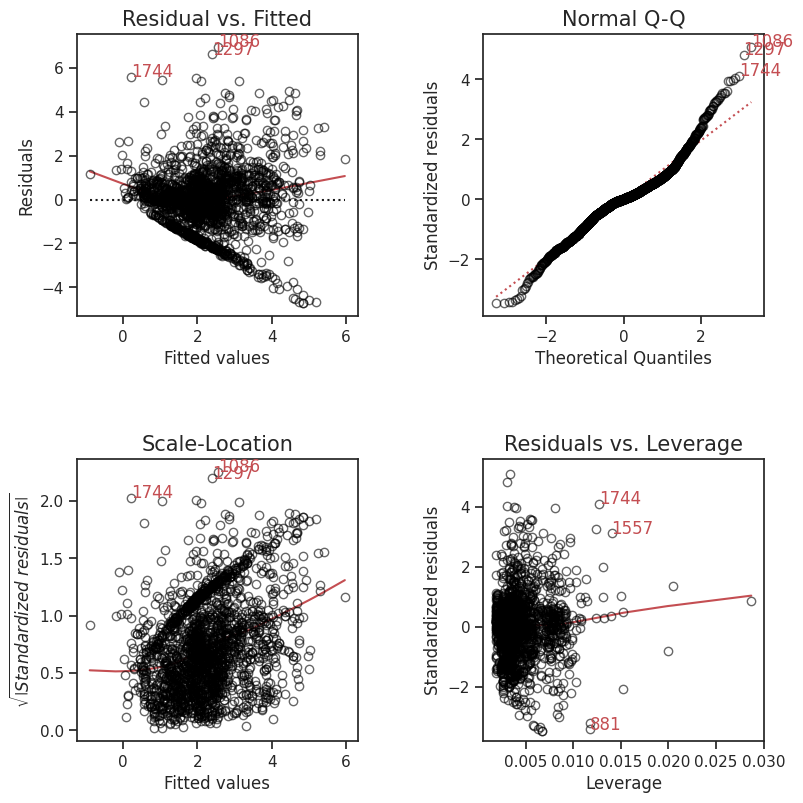

In [ ]:
plt.figure(figsize=(8, 8))
lmdiag.plot(results);

In [ ]:
cleaned_data.drop('gia_ca', axis=1)

dien_tich  phong_ngu  phong_ve_sinh  giay_to  ho_tro_vay  noi_that  \
0          88.0        3.0            2.0        1           0         0   
1          80.0        3.0            2.0        1           0         0   
3          45.0        1.0            1.0        1           1         1   
4          83.9        3.0            2.0        1           0         1   
5         104.0        2.0            2.0        1           1         0   
...         ...        ...            ...      ...         ...       ...   
4172       85.0        3.0            2.0        1           1         1   
4174       70.0        1.0            1.0        0           1         1   
4175       70.0        1.0            1.0        0           0         1   
4177       46.5        1.0            1.0        1           0         0   
4179       85.0        2.0            2.0        1           0         0   

      vi_tri_hn  vi_tri_hcm  vi_tri_other  
0             1           0             0  
1             1           0             0  
3             0           0             1  
4             1           0             0  
5             1           0             0  
...         ...         ...           ...  
4172          1           0             0  
4174          0           0             1  
4175          0           0             1  
4177          0           1             0  
4179          0           0             1  

[2080 rows x 9 columns]

In [ ]:
calculate_vif(cleaned_data.drop(['gia_ca', 'vi_tri_other'], axis=1))

Feature        VIF
0      dien_tich  29.707095
1      phong_ngu  29.725386
2  phong_ve_sinh  26.715198
3        giay_to   7.418631
4     ho_tro_vay   1.559547
5       noi_that   2.606426
6      vi_tri_hn   2.926197
7     vi_tri_hcm   1.746498

In [ ]:
calculate_vif(cleaned_data[['dien_tich']])

ValueError: zero-size array to reduction operation maximum which has no identity

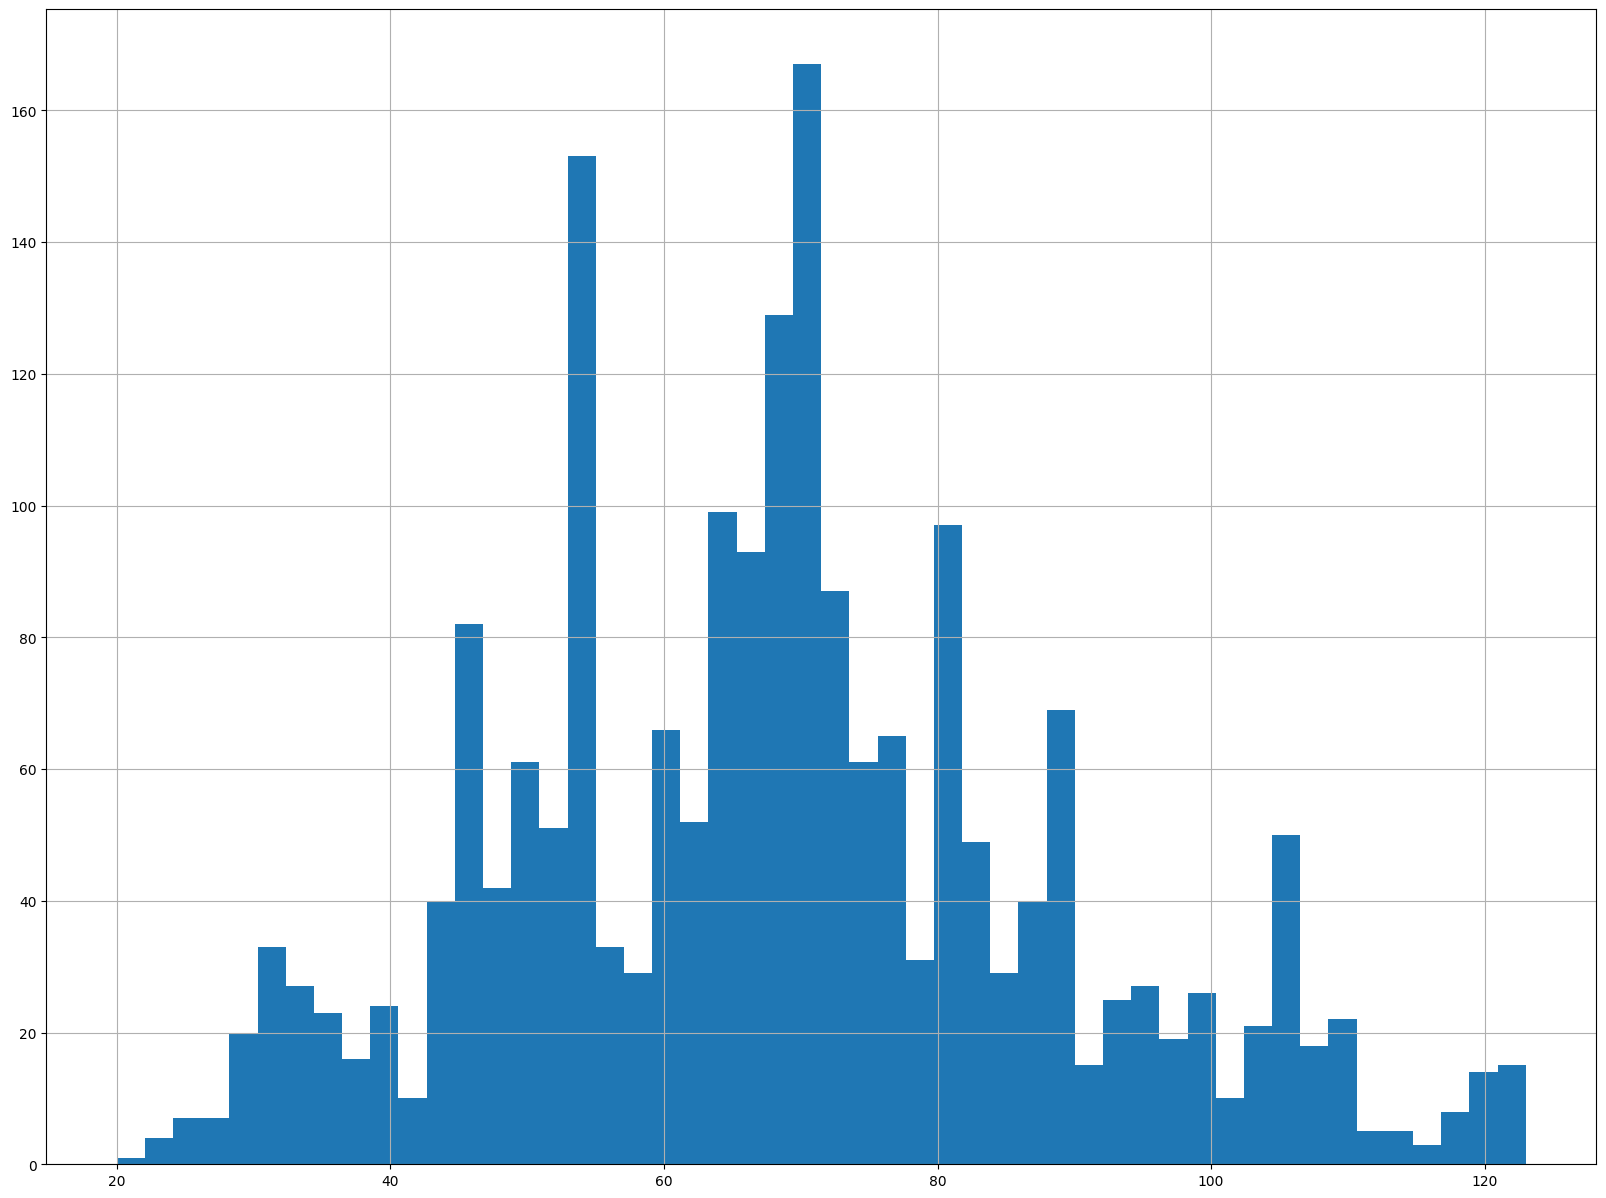

In [ ]:
cleaned_data['dien_tich'].hist(bins=50, figsize=(20, 15))
plt.show()

In [ ]:
features = cleaned_data.drop('gia_ca', axis=1).columns
print(features)
for cols in itertools.combinations(features, 1):
    print(list(cols))
    vif_data = pd.DataFrame()
    vif_data["feature"] = features

    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(len(features))]
    print(vif_data)

Index(['dien_tich', 'phong_ngu', 'phong_ve_sinh', 'giay_to', 'ho_tro_vay',
       'noi_that', 'vi_tri_hn', 'vi_tri_hcm', 'vi_tri_other'],
      dtype='object')
['dien_tich']


KeyError: "['vi_tri_hn', 'vi_tri_hcm', 'vi_tri_other'] not in index"

In [ ]:
# Standardize the predictor variables
standardized_data = (cleaned_data - cleaned_data.mean()) / cleaned_data.std()
standardized_data['gia_ca'] = cleaned_data['gia_ca']  # Ensure the dependent variable is not standardized

var_set = standardized_data.columns.tolist()
var_set.remove('gia_ca')
best_rsquared_adj = -float('inf')
best_formula = ''
best_results = None
best_l_subset = None

# Remove predictors with near-zero variance
threshold = 1e-5  # Adjust the threshold as needed
near_zero_variance_predictors = [col for col in var_set if standardized_data[col].var() < threshold]
for nzv in near_zero_variance_predictors:
    var_set.remove(nzv)

for l in range(1, len(var_set) + 1):
    for l_subset in itertools.combinations(var_set, l):
        formula = 'gia_ca~' + '+'.join(l_subset)
        try:
            model = smf.ols(formula=formula, data=standardized_data)
            results = model.fit()
            rsquared_adj = results.rsquared_adj
            variables = results.model.exog
            vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
            if (rsquared_adj > best_rsquared_adj) and max(vif) <= 5:
                best_rsquared_adj = rsquared_adj
                best_formula = formula
                best_results = results
                best_l_subset = l_subset
                print(best_formula, rsquared_adj, max(vif))
        except Exception as e:
            print(f"Error with formula {formula}: {e}")

print("Best formula:", best_formula)
print("Best adjusted R-squared:", best_rsquared_adj)
print("Best subset of predictors:", best_l_subset)

find_best_model(cleaned_data)


gia_ca~dien_tich 0.2888072855763255 1.0000000000000004
gia_ca~dien_tich+phong_ngu 0.3033406708405766 2.273385401395967
gia_ca~dien_tich+vi_tri_hcm 0.3081886754167156 1.0008275553398553
gia_ca~dien_tich+phong_ngu+giay_to 0.3093293373372088 2.278485087009376
gia_ca~dien_tich+phong_ngu+vi_tri_hcm 0.31813039446105107 2.3298342432531207
gia_ca~dien_tich+phong_ve_sinh+vi_tri_hcm 0.3184701665226113 1.7371668709399863


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


gia_ca~dien_tich+phong_ngu+phong_ve_sinh+vi_tri_hcm 0.32187518149624395 2.942336267003312
gia_ca~dien_tich+phong_ngu+giay_to+vi_tri_hcm 0.3236586378933921 2.3341330690379962
gia_ca~dien_tich+phong_ve_sinh+giay_to+vi_tri_hcm 0.32367689691084134 1.7441204962431647


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero

gia_ca~dien_tich+phong_ngu+phong_ve_sinh+giay_to+vi_tri_hcm 0.32694633858591104 2.9430529799524305


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero

gia_ca~dien_tich+phong_ngu+phong_ve_sinh+giay_to+ho_tro_vay+vi_tri_hcm 0.3277906921533631 2.944524251953823
gia_ca~dien_tich+phong_ngu+phong_ve_sinh+giay_to+vi_tri_hn+vi_tri_hcm 0.32822554874073817 2.962816915138552


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero

gia_ca~dien_tich+phong_ngu+phong_ve_sinh+giay_to+ho_tro_vay+noi_that+vi_tri_hcm 0.3284750762321964 2.944527846680744
gia_ca~dien_tich+phong_ngu+phong_ve_sinh+giay_to+ho_tro_vay+vi_tri_hn+vi_tri_hcm 0.3289395594994995 2.9637973656576997


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero

gia_ca~dien_tich+phong_ngu+phong_ve_sinh+giay_to+ho_tro_vay+noi_that+vi_tri_hn+vi_tri_hcm 0.3293401673331243 2.964216548066861


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Best formula: gia_ca~dien_tich+phong_ngu+phong_ve_sinh+giay_to+ho_tro_vay+noi_that+vi_tri_hn+vi_tri_hcm
Best adjusted R-squared: 0.3293401673331243
Best subset of predictors: ('dien_tich', 'phong_ngu', 'phong_ve_sinh', 'giay_to', 'ho_tro_vay', 'noi_that', 'vi_tri_hn', 'vi_tri_hcm')


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# prompt: create a function that try every combinations of variables in cleaned_data except for 'gia_ca' on a linear model. Print out the formula, adjusted R-squared of the best formula that has the highest adjusted R-squared and VIF <= 5

def find_best_model(df):
  best_model = None
  best_vif = 100
  best_rsquared = 0
  for cols in itertools.combinations(df.drop('gia_ca', axis=1).columns, 1):
    formula = 'gia_ca~' + '+'.join(cols)
    model = smf.ols(formula=formula, data=df).fit()
    vif_data = calculate_vif(df[cols])
    if (vif_data['VIF'].max() <= 5) and (model.rsquared_adj > best_rsquared):
      best_model = model
      best_vif = vif_data['VIF'].max()
      best_rsquared = model.rsquared_adj
  print(f'Best Model: {best_model.model.formula}')
  print(f'Best Adjusted R-squared: {best_rsquared}')

find_best_model(cleaned_data)


KeyError: ('dien_tich',)

TypeError: 'Index' object is not callable

In [ ]:
train_set = cleaned_data
var_set = ['dien_tich','phong_ngu','phong_ve_sinh','giay_to','ho_tro_vay','noi_that','vi_tri_hn','vi_tri_hcm', 'vi_tri_other']
best_rsquared_adj = -float('inf')
best_formula = ''
best_results = None
best_l_subset = None
for l in range(1,len(var_set)+1):
  for l_subset in itertools.combinations(var_set,l):
    formula = 'gia_ca~'+'+'.join(l_subset)
    model = smf.ols(formula=formula, data=train_set)
    results = model.fit()
    rsquared_adj = results.rsquared_adj
    variables = results.model.exog
    vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
    if (rsquared_adj > best_rsquared_adj) and max(vif) <= 5:
      best_rsquared_adj = rsquared_adj
      best_formula = formula
      best_results = results
      best_l_subset = l_subset
      print(best_formula, rsquared_adj, max(vif))

gia_ca~ho_tro_vay 0.0007176780011409756 1.5639097744360904
gia_ca~noi_that 0.005172139719839874 2.6
gia_ca~vi_tri_hcm 0.02379734140709744 1.2659768715763846
gia_ca~vi_tri_other 0.03871782723848316 1.4178595773687797
gia_ca~ho_tro_vay+vi_tri_other 0.0387618465100783 1.925633429017065
gia_ca~noi_that+vi_tri_other 0.04056904074180545 3.2899207807308666
gia_ca~vi_tri_hn+vi_tri_hcm 0.047333970753497545 3.393148450244699
gia_ca~ho_tro_vay+vi_tri_hn+vi_tri_hcm 0.04741358886614533 4.111530383465949
gia_ca~noi_that+vi_tri_hn+vi_tri_hcm 0.04961992177156749 4.518657202770486
gia_ca~noi_that+vi_tri_hcm+vi_tri_other 0.0496199217715676 3.9905924664003773


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: Runtim

gia_ca~ho_tro_vay+noi_that+vi_tri_hcm+vi_tri_other 0.049823813211911094 4.401604637372891


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: Runtim

In [ ]:
plt.figure(figsize=(8,8))
lmdiag.plot(results);

Điểm 270 là điểm ngoại lại, nên bị loại bỏ để tránh ảnh hưởng tới kết quả cuối cùng của mô hình.

In [ ]:
df.drop(270, axis=0, inplace = True)

## Xử lý giá trị khuyết

In [ ]:
df[df['pctemployed16_over'].isna()]['pctemployed16_over']

Ta điền các giá trị khuyết bằng hàm sinh các mẫu ngẫu nhiên có Phân phối Chuẩn với Trung bình và Độ lệch chuẩn được tính bằng các giá trị không bị khuyết của biến 'pctemployed16_over'.

In [ ]:
NA = df[df['pctemployed16_over'].isna()]
# Hàm mean() và std() chỉ tính toán với các giá trị không phải NaN nên phù hợp để dùng cho điền khuyết
mean = df['pctemployed16_over'].mean()
std = df['pctemployed16_over'].std()

filler = pd.Series(np.random.normal(loc=mean, scale=std, size=NA.shape[0]), index=NA.index) # Phải có index=NA.index để các giá trị điền khuyết được đúng vị trí index trong df
df['pctemployed16_over'] = df['pctemployed16_over'].fillna(filler)

In [ ]:
df['pctemployed16_over'].loc[NA.index]

In [ ]:
df.isnull().sum()

# Tiền xử lý dữ liệu

Đối với mô hình Linear Regression cơ bản, chuẩn hóa chỉ thay đổi khoảng giá trị của các trọng số nên các metrics đánh giá cuối cùng của mô hình không thay đổi.
=> Trong bài này em sẽ không chuẩn hóa.

Phần này sẽ bao gồm:
1. Chia bộ dữ liệu thành tập các biến dự đoán hay đặc trưng (X) và biến phụ thuộc hay mục tiêu (Y)

In [ ]:
def prepare_X_y(df):
    # Split data into X and y. Return two dataframes
    columns = df.columns.tolist()
    columns.remove('price')
    X = df[columns] # Select features
    y = df['price'] # Select label
    return X, y

X, y = prepare_X_y(df)
print(X.shape)
print(y.shape)

# Lựa chọn đặc trưng

Phần này sẽ bao gồm:
1. Phân tích phân phối của các biến.
2. Phân tích tương quan giữa các biến đặc trưng (X) và biến mục tiêu (Y).

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(df, kind='reg', diag_kind='kde', height=1.5, corner=True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(df.columns, 1):
  plt.subplot(4, 3, i)
  plt.subplots_adjust(hspace=0.5, wspace=0.5)
  sns.histplot(df[column], kde=True)
plt.show()

In [ ]:
# Vẽ heatmap thể hiện tương quan Pearson giữa các biến
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")

**Nhận xét nhanh:**
*   Biến "station_dist" và "price" có khuynh hướng lệch phải, biến "longtitude" có khuynh hướng lệch trái.
*   Khoảng giá trị của các biến không giống nhau.
*   Biến phụ thuộc (price) tương quan nghịch mạnh với biến "station_dist". Điều này có vẻ hợp lý vì ngôi nhà càng gần các trạm metro (Khoảng cách với trạm càng nhỏ) thì di chuyển càng thuận lợi dẫn tới giá nhà sẽ cao hơn.
*   Giữa các biến "station_dist", "num_store",	"latitude" và "longitude" có mối tương quan (thuận hoặc nghịch) đáng quan tâm, đặc biệt là với biến "station_dist" có tương quan nghịch mạnh. Điều này dễ dẫn tới hiện tượng đa cộng tuyến khi xây dựng mô hình tuyến tính.
*   Biến "trans_date" gần như độc lập với biến phụ thuộc (price).


## Loại bỏ biến

Vì biến "trans_date" gần như độc lập với biến phụ thuộc (price) nên ta có thể xem xét loại bỏ mà không làm mất ý nghĩa thống kê.

In [ ]:
X.drop(['trans_date'], axis = 1, inplace = True)

# Huấn luyện mô hình

Phần này sẽ bao gồm:
1. Chia bộ dữ liệu thành tập Train và tập Test (80% cho Training, 20% cho Testing).
2. Tạo một mô hình Linear Regression.
3. Huấn luyện mô hình với dữ liệu Train.


## Chia tập Train-test

In [ ]:
def split_train_test(X, y, train_size=0.8):
    # Dùng hàm train_test_split để chia X và y thành 2 tập: train và test
    # Với train_size là tỉ lệ của tập train và cố định random_state để không bị thay đổi kết quả
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0)
    print(f"Training set size: \tX_train: {X_train.shape} \tY_train: {y_train.shape}")
    print(f"Testing set size: \tX_test: {X_test.shape} \ty_train: {y_test.shape}")
    return X_train, X_test, y_train, y_test

In [ ]:
TRAIN_SIZE = 0.8 # Chọn tỉ lệ tập Train

X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=TRAIN_SIZE)

## Khởi tạo mô hình Linear Regression

In [ ]:
def build_linear_model(X, y):
    # X, y nên lấy từ tập Train
    # Tách tên của các biến X, y để viết hàm hồi quy
    X_variable = list(X.columns.values)
    y_variable = y.name
    data = pd.concat([X, y], axis=1, join='inner')
    formula = y_variable + '~' +'+'.join(X_variable)
    # Dùng hàm Ordinary Least Squares regression (OLS) từ sklearn, input là hàm hồi quy (có bias) và dữ liệu của các biến (X, y)
    model = smf.ols(formula=formula, data=data)
    # Fit/Train model
    results = model.fit()
    return results

# Huấn luyện mô hình với tập Train
model = build_linear_model(X_train, y_train)

# Đánh giá mô hình

Phần này sẽ bao gồm:
1. Đánh giá mô hình đã được huấn luyện bằng Mean Squared Error (MSE).
2. Trực quan hóa giá nhà (price) thực tế so với giá nhà mô hình dự đoán.
3. Đánh giá và phân tích sâu hơn.

## Đánh giá bằng MSE

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred_train = model.predict(X_train)
print("Train MSE: ", mean_squared_error(y_pred_train, y_train))
y_pred_test = model.predict(X_test)
print("Test MSE: ", mean_squared_error(y_pred_test, y_test))

## Trực quan hóa

In [ ]:

plt.figure()
plt.scatter(y_test, y_pred_test)
plt.plot(y_test, y_test, label='line', color='red', linewidth=1)
plt.suptitle('Actual vs. Predicted house prices', fontsize=20)
plt.xlabel('Actual', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.tight_layout()
plt.show()

**Nhận xét nhanh:**
*   Điểm MSE khá lớn cho thấy đường fitted của mô hình chưa được tốt.
*   Test MSE thấp hơn Train MSE có thể là do kích thước và phương sai của tập Test nhỏ hơn tập Train nhiều.
*   Nhìn vào biểu đồ trực quan hóa thì ta thấy đường fitted của mô hình dường như không bắt được xu hướng của các điểm dữ liệu.
*   Nhìn vào phân bố của các điểm dữ liệu, ta đoán có thể một hàm parabol sẽ phù hợp hơn với bộ dữ liệu này.



## Đánh giá và phân tích sâu hơn

In [ ]:
model.summary()

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

In [ ]:
plt.figure(figsize=(8, 8))
lmdiag.plot(model);

**Nhận xét:**
*   Điểm VIF của biến "latitude" và "longtitude" lớn hơn 5 rất nhiều cho thấy đã xảy ra đa cộng tuyến (hiện tượng phụ thuộc tuyến tính) giữa các biến dự đoán (X). Điều này vi phạm giả định các biến dự đoán phải độc lập tuyến tính với nhau.
*   Điểm p-value của biến "longtitude" lớn nghĩa là trong mô hình hiện tại, biến này không có ý nghĩa thống kê và có thể làm giảm Precision của mô hình.
*   Trên biểu đồ "Residual vs. Fitted" ta thấy các điểm bị co cụm và lệch qua phải (Trong khi phải phân tán đều, ngẫu nhiên trên dưới trục Residual = 0). Điều này cho thấy có thể tồn tại tương quan phi tuyến giữa các biến dự đoán (X) và biến phụ thuộc (Y hay giá nhà).
*   Trên biểu đồ "Normal Q-Q" ta thấy hầu hết các điểm đều nằm dọc trên 1 đường chéo. Điều này cho thấy các Residuals có phân phối chuẩn (Giả định phân phối chuẩn của phần dư (Residuals) không bị vi phạm).
*   Trên biểu đồ "Scale-Location" ta thấy đường màu đỏ gần như nằm ngang cho thấy phương sai của Residual (phần dư) gần như không thay đổi.

# Chỉnh sửa Mô hình

Do biến "price" bị lệch phải nhẹ và có khả năng tồn tại mối quan hệ phi tuyến đối với các biến độc lập, ta thêm vào biến biến đổi log(price).

In [ ]:
y_train_log = np.log(y_train)
y_train_log.name = 'log_price'

Vì mô hình em muốn hướng tới phải mang tính giải thích cao hơn tính dự đoán, ta lựa chọn các mô hình dựa theo tiêu chuẩn R^2 hiệu chỉnh cao nhất với VIF tối đa là 5.

Vì tổ hợp biến biến phải xét là bé (2^5 = 32), nên ta chọn tập hợp con tốt nhất thỏa tiêu chuẩn đã nêu trên.

In [ ]:
def standardize(x):
    y = x - x.mean()
    sd = x.std()
    return y / sd

In [ ]:
train_set = pd.concat([X_train, y_train_log], axis=1, join='inner')
train_set = train_set.apply(standardize, axis=0)
var_set = ['age','station_dist', 'num_store', 'latitude', 'longtitude']
best_rsquared_adj = -float('inf')
best_formula = ''
best_results = None
best_l_subset = None
for l in range(1,len(var_set)+1):
  for l_subset in itertools.combinations(var_set,l):
    formula = 'log_price~'+'+'.join(l_subset)
    model = smf.ols(formula=formula, data=train_set)
    results = model.fit()
    rsquared_adj = results.rsquared_adj
    variables = results.model.exog
    vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
    if (rsquared_adj > best_rsquared_adj) and max(vif) <= 5:
      best_rsquared_adj = rsquared_adj
      best_formula = formula
      best_results = results
      best_l_subset = l_subset
      print(best_formula, rsquared_adj, max(vif))

In [ ]:
model = smf.ols(formula='log_price~age+station_dist+num_store+latitude', data=train_set)
results = model.fit()
results.summary()

In [ ]:
sns.heatmap(train_set.drop(columns = ['longtitude']).corr(), annot = True, cmap="YlGnBu")

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = train_set.drop(columns = ['longtitude', 'log_price']).columns
vif_data["VIF"] = [variance_inflation_factor(train_set.drop(columns = ['longtitude', 'log_price']).values, i) for i in range(len(train_set.drop(columns = ['longtitude', 'log_price']).columns))]
print(vif_data)

In [ ]:
plt.figure(figsize=(8, 8))
lmdiag.plot(results);

**Nhận xét:**
*   Điểm VIF các biến dự đoán đều bé hơn 5 cho thấy không xảy ra đa cộng tuyến (hiện tượng phụ thuộc tuyến tính) giữa các biến dự đoán (X).
*   Adjusted R-squared cho thấy với 2 biến "age" và "station_dist", mô hình giải thích được 57,1% ý nghĩa của giá nhà được dự đoán.
*   Không giải quyết được vi phạm về giả định tương quan tuyến tính giữa biến dự đoán và biến phụ thuộc.

# Kết luận

Phần này sẽ bao gồm:
1. Tổng hợp những thông tin từ việc đánh giá mô hình.
2. Những giới hạn, thiếu xót của mô hình.
3. Giải pháp tiềm năng cho bài toán.

*   Mô hình được chọn là log_price ~ age + station_dist.
*   Với mô hình tốt nhất ta huấn luyện được thì chỉ giải thích được 57,1% ý nghĩa của giá nhà được dự đoán.
*   Các biến dự đoán có tương quan với nhau khá lớn, dẫn tới rất dễ bị đa cộng tuyến.
*   Mô hình vi phạm giả định về tương quan tuyến tính giữa biến dự đoán và biến phụ thuộc.
*   Mô hình tuyến tính có vẻ không phù hợp với bài toán này.
*   Một mô hình phi tuyến như Polynomial Regression có thể sẽ là một mô hình tiềm năng hơn cho bài toán này.
